# CIS 5450 Homework 4: Machine Learning

<ins>Due Date</ins>: **April 4th at 10:00PM EST** \\
<ins>Total Points</ins>: **100 points** (= 83 autograded + 17 manually graded)

**PLEASE READ THE FAQ as you do this assignment!** It's pinned on Ed and we TAs work really hard to keep it updated with everything you might need to know or anything we might have failed to specify. Writing these HWs and test cases gets tricky since students always end up implementing solutions that we did not anticipate and thus could not have prepared the grader correctly for.

# Imports/Setup
Run the following cells to set up the notebook.


Please make sure you enter your **8 digit Penn ID** in the  student ID field below.

In [111]:
%%capture
!pip install -i https://test.pypi.org/simple/ penn-grader==0.5.0
from penngrader.grader import *

# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY.
# IF NOT, THE AUTOGRADER WON'T KNOW WHO TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 53271889                                                                # YOUR PENN-ID GOES HERE AS AN INTEGER

In [112]:
%%writefile config.yaml

grader_api_url: 'https://wyv616tp17.execute-api.us-east-1.amazonaws.com/default/Grader'
grader_api_key: 'Kd32fl3g3p917iM0zwjiO23Bitj4PO9ga4LektOa'

Overwriting config.yaml


In [113]:
grader = PennGrader('config.yaml', 'CIS5450_23Sp_HW4', STUDENT_ID, STUDENT_ID)

PennGrader initialized with Student ID: 53271889

Make sure this correct or we will not be able to store your grade


In [4]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

In [5]:
%%capture
!apt update
!pip install kaggle

# **Part I:** Preprocessing and Modeling in `scikit-learn` (65 points)

## **1.1** Data Loading and Preprocessing [Total: 2 points]

### **1.1.1** Read Data

We are using one CSV for this homework, `reservations.csv` from a Kaggle [dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset?resource=download). The dataset contains a column called `booking_status`, a binary variable indicating whether a reservation was canceled or not.

To get the data in here:
1. Go to this [Kaggle link](https://www.kaggle.com) and create a Kaggle account (unless you already have one)
2. Go to Account and click on "Create New API Token" to get the API key in the form of a json file `kaggle.json`
3. Upload the `kaggle.json` file to the default location in your Google Drive (Please **DO NOT** upload the json file into any _specific_ folder as it will be difficult for us to debug issues if you deviate from these instructions!).

This can be helpful for your project if you decide to use Kaggle.

In [6]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Create the kaggle directory and 
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [8]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [9]:
# Download dataset
!!kaggle datasets download -d ahsan81/hotel-reservations-classification-dataset

['Downloading hotel-reservations-classification-dataset.zip to /content',
 '',
 '  0% 0.00/480k [00:00<?, ?B/s]',
 '',
 '100% 480k/480k [00:00<00:00, 80.5MB/s]']

In [114]:
# Unzip folder in Colab content folder
!unzip /content/hotel-reservations-classification-dataset.zip

Archive:  /content/hotel-reservations-classification-dataset.zip
replace Hotel Reservations.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Hotel Reservations.csv  


In [115]:
# TO-DO: Read the csv file and save it to a dataframe called "df_reservations"
df_reservations = pd.read_csv('/content/Hotel Reservations.csv')

In [116]:
# CHECK: Peak at the first five rows
df_reservations.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


### **1.1.2** Check Nulls and Duplicates

We will find the number of rows with null values and the number of duplicated rows. 

Store the results into `num_nulls` and `num_dups`, respectively.

**Please use pandas functions to compute these values instead of hardcoding them.**

In [117]:
# TO-DO: find number of rows with null values
num_nulls = len(df_reservations[df_reservations.isnull().T.any()])

In [118]:
# TO-DO: find number of duplicated rows
num_dups = len(df_reservations[df_reservations.duplicated()])

In [119]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'drop_null_and_dups', answer = (num_nulls, num_dups))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.2** EDA [Total: 16 points]

Exploratory Data Analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.


### **1.2.1** Understanding Data

A good practice before approaching any data science problem, is to understand the data you will be working with. This can be through descriptive statistics, datatypes, or just a quick tabular visualization. We will be walking through such tasks through Pandas. 

While not explicitly graded, if you don't do this, you are more likely to make mistakes down the line if you don't have a good understanding of your datasets and their range of values.

In [120]:
# Display the datatypes in `df_reservations`
df_reservations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [121]:
# Display the descriptive statistics of `df_reservations`
df_reservations.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


### **1.2.2** Visualizations

There are 8 manually graded points in this section.

#### (a) Number of Canceled and Not Canceled Bookings For Each Month [5 pts]

**Task:** For each month, we want to find the number of canceled bookings and not-canceled bookings.

You should first create a dataframe called `month_status` with the following columns using `reservations_df`:
- `'arrival_month'`
- `'booking_status'`

In [122]:
# TO-DO: create a dataframe month_status 
month_status = df_reservations[['arrival_month','booking_status']]

In [123]:
# Grader Cell (1 point)
grader.grade(test_case_id = 'month_status_df', answer = month_status)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Manually Graded Task:**  We will be using the `seaborn` library for this problem to create a <ins>double histogram</ins> plot using the data in `month_status`. For each month, there will be two bars: one for Canceled bookings and another for Not_Canceled bookings.

Your plot must:
*   Be of figure size `(8,6)`
*   Use `palette = 'husl'` and `shrink = 2`. 
*   Have three-letter abbreviations for months as x-tick labels (for example: Jan, Feb, Mar)
*   Have appropriate titles, axes labels, and a legend
*   Be clearly legible and should **not** have overlapping text or bars.
*   Make sure all months are visible on the x-axis

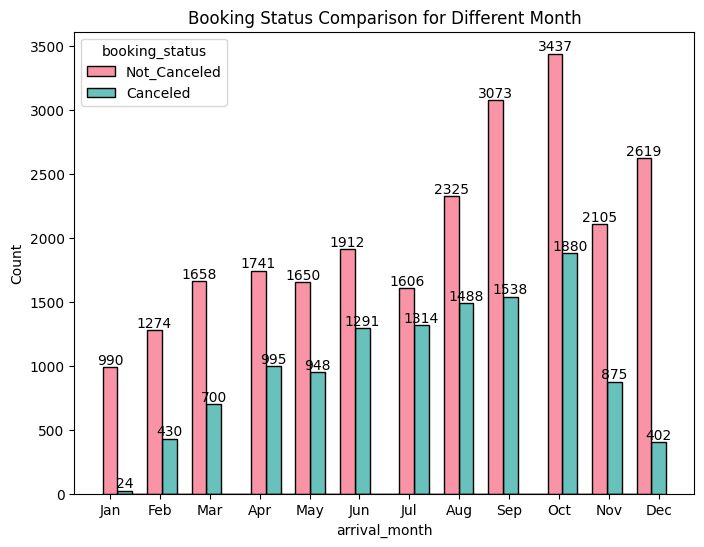

In [124]:
# TO-DO: [MANUALLY GRADED: 4 points]
#   Create a histogram plot which has bars placed side by side in a single plot 
#   showing the number of Canceled and Not_Canceled bookings for each month    

fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(
    data=month_status,
    x="arrival_month",
    hue="booking_status",
    multiple="dodge",
    palette = 'husl',
    shrink=2,
    ax=ax)

ax.set_xticks(ticks=range(1,13),labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_title('Booking Status Comparison for Different Month')

labels = [str(v) if v else '' for v in ax.containers[0].datavalues]
ax.bar_label(ax.containers[0], labels=labels)
labels = [str(v) if v else '' for v in ax.containers[1].datavalues]
ax.bar_label(ax.containers[1], labels=labels)
plt.show()

#### (b) Average Price of a Room for Each Month [5 pts]

**Task:** For each month, we want to find the average cost of rooms.

Please note that there exists a column named `'avg_price_per_room'`, which is the *average price per day* of the given reservation.

We want to find the average cost of a hotel room for *each month*.

You should first create a dataframe called `month_price` with the following columns:
- `'arrival_month'`
- `'avg_price_per_room'`

In [125]:
# TO-DO: create a dataframe month_price 
month_price = df_reservations[['arrival_month','avg_price_per_room']]

In [126]:
# Grader Cell (1 points)
grader.grade(test_case_id = 'month_price_df', answer = month_price)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


**Manually Graded Task:** We will be using the `seaborn` library for this problem to create a <ins>barplot</ins> visualizing the data in `month_price`

Your plot must:
*   Be of figure size (8,6)
*   Use `palette = 'husl'` and `errorbar=None`. 
*   Have three-letter abbreviations for months as x-tick labels (for example: Jan, Feb, Mar)
*   Have appropriate titles and axes labels
*   Be clearly legible and should **not** have overlapping text or bars.

Text(0.5, 1.0, 'Price for Different Month')

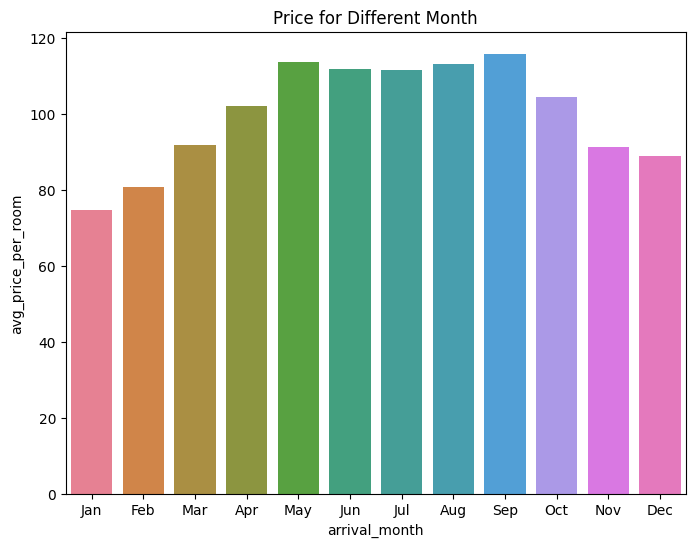

In [127]:
# TO-DO: [MANUALLY GRADED: 4 points]
#   Create a bar plot showing the average price per room for each month
fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(
    data=month_price,
    x='arrival_month',
    y='avg_price_per_room',
    palette='husl',
    errorbar=None,
    ax=ax
)

ax.set_xticks(ticks=range(0,12),labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_title('Price for Different Month')

### **1.2.3** Correlation of Feature Variables

With multiple features, it can be somewhat exhausting to do bivariate analysis on every possible pair of features. While you certainly should, your first instinct should be to check for the correlation between features since certain models (e.g. Linear Regression) won't work well if we have strong multicollinearity.

#### (a) Isolating Numerics from Categorical Features [3 pts]

Before anything else, it may help to create groups of the numeric and categorical variables.

**Task:** is to split the `df_reservations` dataframe into 2 dataframes:

1. `num_df`: This dataframe contains all numerical columns from `df_reservations`

2. `cat_df`: This dataframe contains all categorical columns from `df_reservations`
  - i.e. the columns of non-numeric type or contain boolean values

In the above dataframes, **please do not include `arrival_year`, `arrival_month`, `arrival_date`, `Booking_ID`, `booking_status`**, 
because we do not consider time series here and will be predicting `booking_status` in the immidiate classification problem.

Also, **sort the columns of `numerics_df` and `categorical_df` in alphabetic order**

In [128]:
# TO-DO: Visualize number of unique values and datatype in each column (call .nunique())
df_reservations.nunique()

Booking_ID                              36275
no_of_adults                                5
no_of_children                              6
no_of_weekend_nights                        8
no_of_week_nights                          18
type_of_meal_plan                           4
required_car_parking_space                  2
room_type_reserved                          7
lead_time                                 352
arrival_year                                2
arrival_month                              12
arrival_date                               31
market_segment_type                         5
repeated_guest                              2
no_of_previous_cancellations                9
no_of_previous_bookings_not_canceled       59
avg_price_per_room                       3930
no_of_special_requests                      6
booking_status                              2
dtype: int64

In [129]:
# TO-DO: Form 'numerics_df' and 'categorical_df'
numerics_df = df_reservations.select_dtypes(include=['int','float']).drop(['arrival_year', 'arrival_month', 'arrival_date','required_car_parking_space','repeated_guest'],axis=1)
categorical_df = df_reservations.select_dtypes(exclude=['int','float']).drop(['Booking_ID','booking_status'],axis=1)
categorical_df[['required_car_parking_space','repeated_guest']] = df_reservations[['required_car_parking_space','repeated_guest']]

In [130]:
# TO-DO: sort the columns of `numerics_df` and `categorical_df` in alphabetic order 
numerics_df.sort_index(axis=1, inplace=True)
categorical_df.sort_index(axis=1, inplace=True)

In [131]:
#Grader Cell (3 points)
grader.grade(test_case_id = 'cat_num_df', answer = (numerics_df, categorical_df))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (b) **Correlation Heatmap** [3 pts]

**Manually Graded Task:** Create a correlation matrix using `num_df` and call it `corr_mat`. Using the correlation matrix, generate a correlation heatmap for these numeric features. We will be using Seaborn library to create this heatmap.

Make sure your correlation heatmap meets the following criteria:
*   Ensure that your heatmap is of figure size `(8,8)`: all feature labels should be visible on both the $x$-axis and $y$-axis
*   Use the `RdBu` color map to ensure that negative correlations are red and positive correlations are blue. This is far more intuitive than other ones.
*   Standardize the color scale so that -1 takes the darkest red color, 0 is totally white, and +1 takes the darkest blue color. Remember, the Official Documentation should always be your first point of reference.

Text(0.5, 1.0, 'heatmap for numeric features')

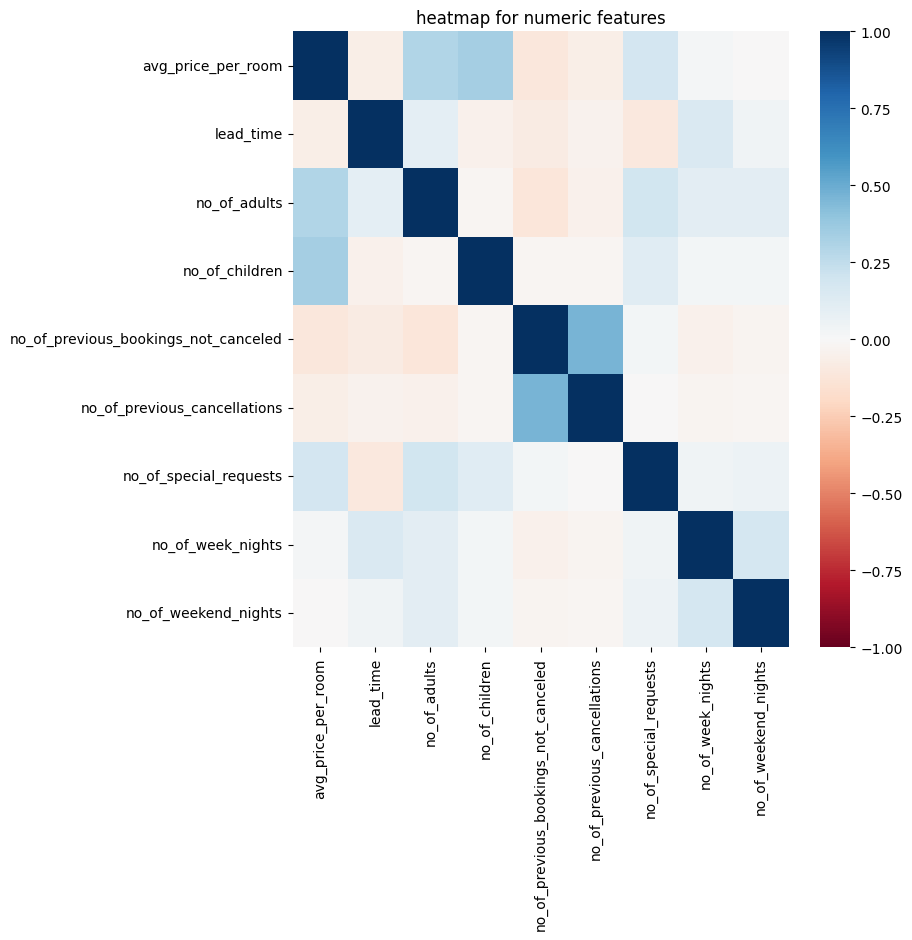

In [132]:
# TO-DO: Plot correlation heatmap (3 points)
corr_mat=numerics_df.corr()

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(
    data=corr_mat,
    vmin=-1,
    vmax=1,
    cmap='RdBu',
    ax=ax
)

ax.set_title('heatmap for numeric features')

## **1.3** Feature Engineering [Total: 4 points]

Feature engineering is the process of applying domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms.

### **1.3.1** One Hot Encoding [2 pts]

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. With one-hot encoding, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. 

One way to one-hot encode in Pandas is by using `pd.get_dummies()` . The documentation can be found [here](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html). 

**Input:** Perform operations on `df_reservations`

**Task:**
- Use `pd.get_dummies()` to one hot encode the following columns: 
  - `"type_of_meal_plan"`
  - `"room_type_reserved"`
  - `"market_segment_type"`
- Save your result in the dataframe `encoded_df_reservations`.

**Note:** Do <ins>NOT</ins> modify the column names. Use the default names `pd.get_dummies()` generates.

In [133]:
# TO-DO: drop "Booking_ID" column from `df_reservations`
df_reservations.drop(['Booking_ID'],axis=1,inplace=True)

In [134]:
# TO-DO: create dataframe 'encoded_df_reservations' that contains the appropriate one hot encoded columns and the original numerical columns
df_reservations_onehot = pd.get_dummies(df_reservations[['type_of_meal_plan','room_type_reserved','market_segment_type']])
encoded_df_reservations = pd.concat([df_reservations.drop(['type_of_meal_plan','room_type_reserved','market_segment_type'],axis=1),df_reservations_onehot],axis=1)

In [135]:
# CHECK: display the first two rows of 'encoded_df_reservations'
encoded_df_reservations.head(2)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,...,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Aviation,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
0,2,0,1,2,0,224,2017,10,2,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,2,3,0,5,2018,11,6,0,...,0,0,0,0,0,0,0,0,0,1


In [136]:
#Grader Cell (2 points)
grader.grade(test_case_id = 'one_hot_encoded', answer = encoded_df_reservations.head(10))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.3.2** Change 'booking_status' to Boolean [2 pts]

We will use `encoded_df_reservations` starting from 1.3.2

We will be predicting the `"booking_status"` for our classification problem. Let's convert this column into a Boolean column. 

**Input:** Use `encoded_df_reservations` in forward sections

**Task:** If the `"booking_status"` is "Canceled", set it to 1. Otherwise, set it to 0.

_(Aside: while this may sound oddly familiar, please note that this is not the same as your Midterm 1)_

In [137]:
# TO-DO: canceled = 1, not canceled = 0 
encoded_df_reservations['booking_status'] = (encoded_df_reservations['booking_status']=='Canceled').astype(int)

In [138]:
# Grader Cell (2 points)
grader.grade(test_case_id = 'boolean_booking', answer = encoded_df_reservations.head(20)['booking_status'])

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.4** Modeling (sklearn) [Total: 43 points]

### **1.4.1** Preprocessing: Create Features and Label and Split Data into Train and Test [4 pts]

Now that we have explored and cleaned our dataset, let's prepare it for a machine learning task. In this homework, you will work with various models and attempt to predict whether a room booking will be cancelled or not.

The features will be all the variables in the dataset **except** `"booking_status"`, which will act as the label for our problem. First, store these two as `features` (pd.DataFrame) and `target` (pd.Series), respectively.

In [139]:
# TO-DO: stores features dataframe into variable called "features"
features = encoded_df_reservations.drop(['booking_status'],axis=1)

In [140]:
# TO-DO: store the classification target variable into "target"
target = encoded_df_reservations['booking_status']

Now, use scikit-learn's `train_test_split` function to split data for regression into train and test sets. The split should be 80-20 meaning 80% for training and rest for testing.

**_IMPORTANT_:** Please set the `seed` variable to 42, then set the parameter to `random_state = seed`, and then finally store the resulting splits as `X_train, X_test, y_train,` and `y_test`.

In [141]:
# TO-DO: Assign appropriate value to seed and conduct 80/20 train-test split with random_state = seed
seed=42
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state = seed)

In [142]:
# Grader Cell (4 points)
grader.grade(test_case_id = 'train_test_split_classification', answer = (X_train.shape, X_test.shape,
                                                                         y_train.shape, y_test.shape,
                                                                         seed, Counter(y_test)))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.4.2** Classification Models

#### (a) Logistic Regression [2 pts]

Fit a Logistic regression classifier on the `X_train` and `y_train` with the default hyperparameters. Calculate the accuracy of the model on the test set using the `score` method and store it in a variable named `log_acc`

In [143]:
# TO-DO: Import required libraries
from sklearn.linear_model import LogisticRegression

# TO-DO: Initialize model with default parameters and fit it on the training set
model = LogisticRegression()
model.fit(X_train, y_train)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = model.predict(X_test)

# TO-DO: Find the accuracy and store the value in `log_acc`
log_acc = model.score(X_test, y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [144]:
# Grader Cell [2 points]
grader.grade(test_case_id = 'check_log_clf', answer = log_acc)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (b) Random Forest Classifier [3 pts]

Fit a Random Forest classifier on the `X_train` and `y_train` with the following hyperparameters: 
- balanced class_weight
- 120 estimators
- maximum depth of 30
- random seed set to 42

Calculate the accuracy of the model on the test set using the `score` method and store it in a variable named `rf_acc`.
Also, compute a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for your prediction and save it as `rf_confusion`.

In [145]:
# TO-DO: Import required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# TO-DO: Initialize model with default parameters and fit it on the training set
clf = RandomForestClassifier(n_estimators=120, max_depth=30, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = clf.predict(X_test)

# TO-DO: Find the accuracy and store the value in `rf_acc`
rf_acc = clf.score(X_test, y_test)

# TO-DO: Compute the confusion matrix and save it to `rf_confusion`
rf_confusion = confusion_matrix(y_test, y_pred)

In [146]:
# Grader Cell (3 points)
grader.grade(test_case_id = 'check_rf_clf', answer = (rf_acc, rf_confusion))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (c) PCA to Reduce Dimensionality [4 + 2 pts]

The goal of Principal Component Analysis is to reduce number of dimensions of our features.

_**Initial PCA**_

As a first step, instantiate the `PCA` class from scikit-learn and fit it on your training set. We are not reducing the dimensionality of our data in this step but rather trying to find what would be the ideal number of Principal Components to choose. So keep all Principal Components for this step

Please remember that PCA is **not** scale-invariant! What does this imply you need to do first? This requires conceptual understanding to implement so make sure you _watched_ the corresponding lecture and recitation!

<ins>WARNING</ins>: It is _CRITICALLY_ important that you understand the difference between the `.fit_transform`, `.fit` and `.transform` methods. This has been the most common mistake students have made in this homework, which has potentially made it more difficult for them. Without fully understanding this, those same students have gone on to make the same mistakes in the final exam and their project. We cannot emphasize this enough!

In [147]:
# TO-DO: Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [148]:
# TO-DO: Intermediate step to address fac that PCA is not scale-invariant
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train) 


# TO-DO: Instantiate and Fit PCA
pca = PCA()
pca.fit(X_train_scaled)

PCA()

_**Cumulative Explained Variance Ratios**_

Create an array of explained variance ratios and store it into a variable called `explained_variance_ratios`. Also, calculate the _cumulative_ explained variance ratios and store that into another variable called `cum_evr`.

In [149]:
# TO-DO: Save the explained variance ratios into variable called "explained_variance_ratios"
explained_variance_ratios = pca.explained_variance_ratio_

# TO-DO: Save the CUMULATIVE explained variance ratios into variable called "cum_evr"
cum_evr = np.cumsum(explained_variance_ratios)

In [150]:
#Grader cell (2 points)
grader.grade(test_case_id = 'check_pca_explained_variance', answer = (explained_variance_ratios, cum_evr))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now plot the _cumulative_ `explained_variance_ratio` against the number of components to decide the number of components you should keep (this should look very similar to a visualization in lecture). Also add a horizontal line that represents the 80% of the variance as a threshold.

As before, you should ensure that the plot follows the best practices you've developed over the past 2 plotting exercises in this HW (Labelling the axes and adding title to the plot, readability, etc.). **This will be manually graded for 2 points**

_**CAUTION:** Recall that Python starts counting from 0, but this would make it very intuitive when reading from your graph. We strongly recommend that you modify the x-axis of your graph so that the **number of components begins at 1**. Otherwise, you may risk making silly mistakes in the subsequent sections._

Text(0, 0.5, 'Cumulative Explained Ratio')

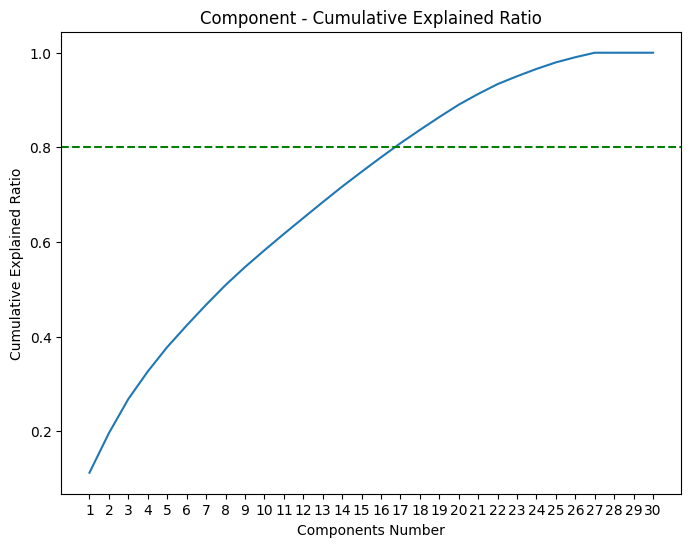

In [151]:
# TO-DO: find optimal num components to use (n) by plotting explained variance ratio (2 points)
fig, ax = plt.subplots(figsize=(8,6))

sns.lineplot(
    data=cum_evr,
    ax=ax
)

plt.axhline(y=0.8, color='g', linestyle='--')

ax.set_xticks(ticks=range(0,30),labels=range(1,31))
ax.set_title('Component - Cumulative Explained Ratio')
ax.set_xlabel('Components Number')
ax.set_ylabel('Cumulative Explained Ratio')

_**Final PCA**_

Using your results above to help you decide the number of components to keep, choose a number (`n`) that explains **at least 80% of total variance** in the dataset. Then re-fit and transform your PCA on the training set using the number of components you decided.

Remember that your PCA should be trained on the training set (`X_train`) but only transformed on the test set (`X_test`).

Call your transformed set of principal components `X_test_pca` in order to submit it to the autograder.

In [152]:
# TO-DO: Get transformed set of principal components on x_test

# 1. Refit and transform on training with parameter n (as deduced from the last step) 
n = len(cum_evr[cum_evr<0.8])+1
pca = PCA(n_components=n)
X_train_pca = pca.fit_transform(X_train_scaled)

# 2. Transform on Testing Set and store it as `X_test_pca`
X_test_scaled = scale.transform(X_test) 
X_test_pca = pca.transform(X_test_scaled)

In [153]:
# Grader cell (2 points)
grader.grade(test_case_id = 'check_fitted_pca', answer = X_test_pca)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (d) Logistic Regression with PCA [4 pts]

1. Fit the logistic regression on your Final Principal Components data using your optimal `n`. Name the model `log_reg_pca`
2. Make predictions on the **test** set and store this as `y_pred`.
3. Report accuracy for the **test** set and call it `test_accuracy`

In [154]:
# TO-DO: Initialize `log_reg_pca` model with default parameters and fit it on the PCA transformed training set
log_reg_pca = LogisticRegression()
log_reg_pca.fit(X_train_pca, y_train)

# TO-DO: Use the model to predict on the PCA transformed test set and save these predictions as `y_pred`
y_pred = log_reg_pca.predict(X_test_pca)

# TO-DO: Find the accuracy and store the value in `test_accuracy`
test_accuracy = log_reg_pca.score(X_test_pca, y_test)

In [155]:
# Grader (4 points)
grader.grade(test_case_id = 'check_log_reg_pca', answer = (test_accuracy, log_reg_pca.n_features_in_, y_pred))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.4.3.0** Regression: Split Data into Train and Test [4 pts]


**Task:** 
 We will be predicting `avg_price_per_room` for regression models.

 Drop the columns: `'arrival_year'`,`arrival_month`, `'arrival_date'`,`'no_of_previous_cancellations'`, `'no_of_previous_bookings_not_canceled'` `'booking_status'` 
 from `encoded_df_reservations` and save the dataframe to `reg_df_reservations`. Then, use scikit-learn's `train_test_split` function to split data for regression into train and test sets. The split should be 80-20 meaning 80% for training and rest for testing.


**_IMPORTANT_: Please set the `seed` variable to 42 and then set the parameter to `random_state = seed`** and store the resulting splits as `X_train, X_test, y_train,` and `y_test`.

In [156]:
# TO-DO: drop arrival_year, arrival_month, arrival_date, no_of_previous_cancellations, no_of_previous_bookings_not_canceled,booking_status
# TO-DO: save the dataframe to reg_df_reservations

reg_df_reservations = encoded_df_reservations.drop(['arrival_year','arrival_month', 'arrival_date','no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled','booking_status'],axis=1)

In [157]:
# TO-DO: stores features dataframe into variable called "features"
features = reg_df_reservations.drop(['avg_price_per_room'],axis=1)

# TO-DO: store the classification target variable  (`avg_price_per_room`) into "target"
target = reg_df_reservations['avg_price_per_room']


In [158]:
# TO-DO: Assign appropriate value to seed and conduct 80/20 train-test split with random_state = seed
seed=42
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state = seed)

In [159]:
# Grader cell (4 points)
grader.grade(test_case_id = 'train_test_split_regression', answer = (X_train.shape, X_test.shape,
                                                                     y_train.shape, y_test.shape,
                                                                     seed, len([i for i in y_test if i < 100])))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.4.3.1** Regression Models

In this section, we will switch from classification models to regression models.

Let's use the features we created in 1.4.3.0 to create regression models and predict the **average price per room**.

#### (a) Linear Regression (Unregularized) [5 pts]

Use the `LinearRegression` class in scikit-learn to perform Linear Regression. Initialize a Linear regression model named `reg` with default parameters, fit the model to the training set, and then make predictions on the testing set.

Save your predictions in an array named `y_pred`, and report your R-squared score (saved it as a variable called `lin_reg_score`).

In [160]:
# TO-DO: Import required libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# TO-DO: Initialize model with default parameters and fit it on the training set
reg = LinearRegression()
reg.fit(X_train, y_train)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = reg.predict(X_test)

# TO-DO: Find the R-squared score and store the value in `lin_reg_score`
lin_reg_score = r2_score(y_test, y_pred)

In [161]:
# Grader (5 points)
grader.grade(test_case_id = 'check_linear_reg', answer = (lin_reg_score, reg.coef_, reg.intercept_))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (b) Ridge Regression [2 pts]

Use the `Ridge` class in scikit-learn to perform $L_2$ Regularized Linear Regression. Initialize a Ridge regression model named `reg_ridge` with regularization strength `alpha = 10`, fit the model to the training set, and then make predictions on the testing set.

**Note:** Recall that Ridge regression is not scale-invariant, so you will need to standardize the features prior to modeling.

Report your $R^2$ score and save it as a variable called `ridge_score`.

In [162]:
# TO-DO: Intermediate step to address scale-invariance
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train) 

In [163]:
# TO-DO: Import required libraries
from sklearn.linear_model import Ridge

# TO-DO: Initialize model with alpha = 10 (keep other hyperparameters as default values) and fit it on the training set
reg_ridge = Ridge(alpha=10)
reg_ridge.fit(X_train_scaled, y_train)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
X_test_scaled = scale.transform(X_test)
y_pred = reg_ridge.predict(X_test_scaled)

# TO-DO: Find the R-squared score and store the value in `ridge_score`
ridge_score = r2_score(y_test, y_pred)

In [164]:
# Grader (2 points)
grader.grade(test_case_id = 'check_ridge_reg', answer = (ridge_score, reg_ridge.alpha))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


_**Exam-Style Practice Questions:**_

_(While we will NOT grade this for the purpose of the HW, it is in your best interest to take just 30-60 seconds to think about this as I may very well put something similar in the final exam!_ 😉_)_

- What do you notice about the $R^2$ scores of the Ridge and unregularized Linear Regression above?
- If Ridge is supposed to "improve" Linear Regression, we may find it unusual if that is not happening here. Under what circumstances would we consider using Ridge over unregularized Linear Regression?
- Would you expect different results if we made `alpha` bigger ($\alpha \rightarrow \infty$)? smaller ($\alpha \rightarrow 0$)? Why or why not?

In [165]:
lin_reg_score,ridge_score

(0.45067720722116156, 0.45068420345432947)

#### (c) Random Forest Regression [3 pts]

From the results of linear regression and ridge linear regression, we see a linear model may not be ideal for this regression problem. We want a model that can capture the complex relationship between the target variable and the features. Fortunately, we have access to ensemble methods, which combine multiple simple models to improve performance. We will explore the bagging algorithm called Random Forest Regressor using scikit-learn.

Use the `RandomForestRegressor` class in Scikit-learn's ensemble library to perform Random Forest Regression. Initialize a Random Forest regression model named `reg_rf`, fit the model to the training set, and then make predictions on the testing set.

Report your R-squared score and save it as a variable called `rfr_score`, set random state to 42

In [166]:
# TO-DO: Import required libraries
from sklearn.ensemble import RandomForestRegressor

# TO-DO: Initialize model with default parameters and fit it on the training set
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = reg_rf.predict(X_test)

# TO-DO: Find the R-squared score and store the value in `rfr_score`
rfr_score = r2_score(y_test, y_pred)

In [167]:
# Grader (3 points)
grader.grade(test_case_id = 'check_rf_reg', answer = (rfr_score, reg_rf.feature_names_in_, reg_rf.n_outputs_, y_pred))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **1.4.4** K-Means Clustering

K-means clustering is a popular unsupervised machine learning algorithm that is used for grouping similar data points into a predetermined number of clusters. It is a simple and effective algorithm that is widely used in various fields such as image processing, recommendation systems, and customer segmentation.

An elbow plot is a visualization tool used to determine the optimal number of clusters for a dataset. It plots the within-cluster sum of squares (WCSS) against the number of clusters. WCSS is the sum of the squared distance between each data point and its assigned centroid. The elbow plot helps you to choose the number of clusters that minimize the WCSS while avoiding overfitting.

Please refer to [this document](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to find out how to compute the sum of squared distances

**We will be using the same features from the <ins>classification</ins> setting.
To determine the best $k$ for the clustering, let's firstly generate an elbow plot.**
- Consider number of clusters from 2 to 10
- Set parameter `n_init` to 5.
- Set random seed to 0

**The elbow plot (4 points) will be manully graded**
- x-axis is the "number of clusters", i.e. "k".
- y-axis is the within-cluster sum of squares (WCSS) value
- add proper titles for the plot and axis.

Note that standardizing the data before performing k-means clustering is often recommended, but for illustration purpose, we do not standardize the input in this section.

#### (a) Find the best number of clusters with the elbow plot [4 + 3 pts]

In [168]:
# TO-DO: Prepare the data (the same features from the classification setting, i.e. excluding "booking_status")
# stores features dataframe into variable called "features"
features = encoded_df_reservations.drop(['booking_status'],axis=1)

Text(0, 0.5, 'WCSS')

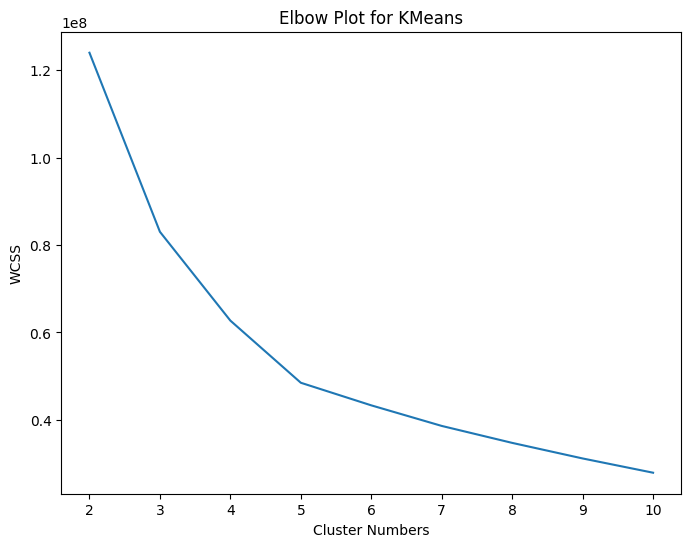

In [169]:
# Import the necessary libraries
from sklearn.cluster import KMeans

# TO-DO: [MANUALLY GRADED: 4 points]
#   for k ranges from 2 to 10, fit on "features" to generate an elbow plot
elbow_list=[]
for k in range(2,11):
  elbow_list.append(KMeans(n_clusters=k, random_state=0, n_init=5).fit(features).inertia_)

fig, ax = plt.subplots(figsize=(8,6))

sns.lineplot(
    data=elbow_list,
    ax=ax
)

ax.set_title('Elbow Plot for KMeans')
ax.set_xticks(ticks=range(0,9),labels=range(2,11))
ax.set_xlabel('Cluster Numbers')
ax.set_ylabel('WCSS')

In [170]:
# TO-DO: choose the best number of clusters (the elbow) and fill in
number_of_cluster = 5

# TO-DO: fill in the sum of squared distances for the best number of clusters
wcss_elbow = elbow_list[3]

In [171]:
# Grader (3 points)
grader.grade(test_case_id = 'kmeans_elbow', answer = (number_of_cluster, wcss_elbow))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### (b) Re-fit with the best number of clusters [3 pts]

In [172]:
# TO-DO: re-run the K-Means clustering with the best number of clusters, save the fitted model to `kmeans`
kmeans = KMeans(n_clusters=5, random_state=0, n_init=5).fit(features)

In [173]:
# Grader (3 points)
grader.grade(test_case_id = 'refit_kmeans', answer = (Counter(kmeans.labels_), kmeans.n_features_in_))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# **Part II:** Distributed Machine Learning with Spark (35  points)

Apache Spark ML is a machine learning library that consists of common learning algorithms and utilities, including classification, regression, clustering, collaborative filtering, dimensionality reduction, and underlying optimization primitives.

**Why Spark ML?**

Moving to the Big Data Era requires heavy iterative computations on very large datasets. Standard implementations of machine learning algorithms require very powerful machines to be able to run. However, depending on high-end machines is not advantageous due to their high price and improper costs of scaling up. The idea of using distributed computing engines is to distribute the calculations to multiple low-end machines (commodity hardware) instead of a single high-end one. _This **definitely speeds up** the learning phase and allows us to create better models._

Read more about it with the python documentation **[here](https://spark.apache.org/docs/latest/ml-guide.html)**.

Run the code below to set up Spark.

## _PENALTY WARNING_:
We will very carefully go through the code in your notebook for this HW. Any student caught trying anything devious like using sklearn to avoid using SparkML in this section will get a **ZERO**.

**Note:** The cell below may take upto **4-5 minutes** to run so be patient!

In [174]:
%%capture

!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [175]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('bigdata-hw4').getOrCreate()
sqlContext = SQLContext(spark)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [176]:
%load_ext sparkmagic.magics

The sparkmagic.magics extension is already loaded. To reload it, use:
  %reload_ext sparkmagic.magics


In [177]:
# Graph section
import networkx as nx

# SQLite RDBMS
import sqlite3

import os
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

## **2.1** Initializing Spark Data [Total: 2 Points]

We have the Spark setup ready, and we now need the data for our ML algorithms. We will use the data you processed in Part I, but in Spark. 

### **2.1.0** Converting the Pandas Dataframe into a Spark Dataframe

Read the `encoded_df_reservations` that you created in Part I into a Spark dataframe (`sdf`) and name the SDF as `reservations_sdf`. \\
**Note:** Just like Part I, the target variable (label) for this section will be `"booking_status"`.

In [178]:
#TO-DO: Read encoded_df_reservations into a Spark Dataframe called reservations_sdf
reservations_sdf = spark.createDataFrame(encoded_df_reservations)

Print out the Dataframe Schema and verify the datatypes. If you did everything correctly so far, the schema should be:
```
root
 |-- no_of_adults: long (nullable = true)
 |-- no_of_children: long (nullable = true)
 |-- no_of_weekend_nights: long (nullable = true)
 |-- no_of_week_nights: long (nullable = true)
 |-- required_car_parking_space: long (nullable = true)
 |-- lead_time: long (nullable = true)
 |-- arrival_year: long (nullable = true)
 |-- arrival_month: long (nullable = true)
 |-- arrival_date: long (nullable = true)
 |-- repeated_guest: long (nullable = true)
 |-- no_of_previous_cancellations: long (nullable = true)
 |-- no_of_previous_bookings_not_canceled: long (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- no_of_special_requests: long (nullable = true)
 |-- booking_status: double (nullable = true)
 |-- type_of_meal_plan_Meal Plan 1: long (nullable = true)
 |-- type_of_meal_plan_Meal Plan 2: long (nullable = true)
 |-- type_of_meal_plan_Meal Plan 3: long (nullable = true)
 |-- type_of_meal_plan_Not Selected: long (nullable = true)
 |-- room_type_reserved_Room_Type 1: long (nullable = true)
 |-- room_type_reserved_Room_Type 2: long (nullable = true)
 |-- room_type_reserved_Room_Type 3: long (nullable = true)
 |-- room_type_reserved_Room_Type 4: long (nullable = true)
 |-- room_type_reserved_Room_Type 5: long (nullable = true)
 |-- room_type_reserved_Room_Type 6: long (nullable = true)
 |-- room_type_reserved_Room_Type 7: long (nullable = true)
 |-- market_segment_type_Aviation: long (nullable = true)
 |-- market_segment_type_Complementary: long (nullable = true)
 |-- market_segment_type_Corporate: long (nullable = true)
 |-- market_segment_type_Offline: long (nullable = true)
 |-- market_segment_type_Online: long (nullable = true)
```

**Note:** Especially ensure that the target variable is of the datatype `double`. Cast it to the correct datatype, if needed.

In [179]:
# TO-DO: Verify that the schema of your Spark dataframe matches the above
#        Make sure to double-check that the target variable i.e. booking_status is of type "double"
reservations_sdf = reservations_sdf.withColumn("booking_status", reservations_sdf["booking_status"].cast("double"))
reservations_sdf.printSchema()

root
 |-- no_of_adults: long (nullable = true)
 |-- no_of_children: long (nullable = true)
 |-- no_of_weekend_nights: long (nullable = true)
 |-- no_of_week_nights: long (nullable = true)
 |-- required_car_parking_space: long (nullable = true)
 |-- lead_time: long (nullable = true)
 |-- arrival_year: long (nullable = true)
 |-- arrival_month: long (nullable = true)
 |-- arrival_date: long (nullable = true)
 |-- repeated_guest: long (nullable = true)
 |-- no_of_previous_cancellations: long (nullable = true)
 |-- no_of_previous_bookings_not_canceled: long (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- no_of_special_requests: long (nullable = true)
 |-- booking_status: double (nullable = true)
 |-- type_of_meal_plan_Meal Plan 1: long (nullable = true)
 |-- type_of_meal_plan_Meal Plan 2: long (nullable = true)
 |-- type_of_meal_plan_Meal Plan 3: long (nullable = true)
 |-- type_of_meal_plan_Not Selected: long (nullable = true)
 |-- room_type_reserved_Room_Type 1: 

### **2.1.1** Setting Up a VectorAssembler

Great! We have the processed data now. For Spark ML, we need to create a feature column which has all features concatenated as a list, and a single column for labels (which we already have!)
We will use `VectorAssembler()` to create a feature vector from all our features, and we will call this vectorized variable as “features”.

First, list all column names in `reservations_sdf` and store them in a list variable called `all_columns`.

In [180]:
# TO-DO: store all column name in the data_sdf in a list called "all_columns"
all_columns = reservations_sdf.columns

Create a list of column(s) you don't want to include as your features. Name this list `drop_columns`.

In [181]:
# TO-DO: Create "drop_columns"
drop_columns = ['booking_status']

Now, using `drop_columns`, create a list called `feature_columns` that only contains the names of the columns that would be used as features for our ML models.

In [182]:
# TO-DO: Create the "feature_columns" list
feature_columns = [i for i in all_columns if i not in drop_columns]

In [183]:
# Grader cell [2 points]
grader.grade(test_case_id = 'check_feature_columns', answer = feature_columns)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Finally, create a [VectorAssembler](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html) object with the columns that you want to use as features. Name your output column as `features` (i.e. they are the features that will be used for SparkML).

In [184]:
# TO-DO: Import required library and create VectorAssembler object (to be used later)
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
        inputCols=feature_columns,
        outputCol="features")

## **2.2** Preprocessing: Pipeline and Train-Test Split [Total: 3 Points]

Now that we have a VectorAssembler object ready, let's use it on our Spark dataframe to get the concatenated features column. To do this, we implement a [Pipeline](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Pipeline.html), which can be used to streamline multiple preprocessing stages at once. For this data, we just need a single stage with the assembler, but you could have other stages before that where you perform operations on the data like converting categorical strings in the features to numeric values, or do feature scaling operations.

We will create a pipeline with a single stage — the assembler. Fit the pipeline on `reservations_df` to create the transformed dataframe and name it `processed_reservations_sdf`.


In [185]:
# TO-DO: Import required libraries
from pyspark.ml import Pipeline

# TO-DO: Define a pipeline object
pipeline = Pipeline(stages=[assembler])

# TO-DO: Fit and transform the pipeline on the data and store the transformed sdf as "processed_reservations_sdf" 
processed_reservations_sdf = pipeline.fit(reservations_sdf).transform(reservations_sdf)

Now that we have the data in the format we need, we will create our train and test sets.

Conduct a train-test split where 80% of the data is assigned to the training set while the remaining 20% is assigned to the testing set.

- Name these sets as `train_sdf` and `test_sdf` respectively.
- Set the variable `random_seed` to 42 and then add the argument `seed = random_seed` in the function to fix the random state in order to ensure consistency with our results.

In [186]:
# TO-DO: Assign appropriate value to the random_seed variable
random_seed = 42

# TO-DO: Do 80/20 train-test split with seed = random_seed and store them as "train_sdf" and "test_sdf"
train_sdf, test_sdf = processed_reservations_sdf.randomSplit([0.8, 0.2], seed = random_seed)

In [187]:
# Grader (3 points)
grader.grade(test_case_id = 'check_train_test_split_spark', answer = (train_sdf.count(), test_sdf.count(), random_seed))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **2.3** Modeling (SparkML) [Total: 30 Points]

Time to do the cool stuff! We will work on various types of models using SparkML to see the difference in implementation from sklearn.

### **2.3.1** Vanilla Logistic Regression [6 pts]

Let's train an **unregularized** Logistic Regression model to our data and try to predict whether the `booking_status` will be cancelled or not.

This time, we will use "Big" data tools to help us build a Logistic Regression model for binary classification. Look up the documentation online and try to understand how to implement this.

**Note**: Make sure to set the parameter `maxIter` to an appropriate value (e.g. 5) for fast computation.

In [188]:
# TO-DO: Import required library for Logistic Regression
from pyspark.ml.classification import LogisticRegression

# TO-DO: Instantiate and fit Logistic Regression model to training data
lr = LogisticRegression(featuresCol = 'features', labelCol = 'booking_status', maxIter=5)
clfModel = lr.fit(train_sdf)

Calculate the training accuracy using the model's summary and store it in a variable called `train_accuracy`.

In [189]:
# TO-DO: Get training accuracy and store it as `train_accuracy`
train_accuracy = clfModel.summary.accuracy

Now, let's find out how good the model actually is and see if it overfits to the training data.

Predict the labels `"booking_status"` for your test data and store them as `predictions` _(Hint: it is called 'transform' in SparkML)_

In [190]:
# TO-DO: Make predictions on testing set and store it as "predictions"
predictions = clfModel.transform(test_sdf)

To get the test accuracy, we will make use of a **confusion matrix**. It is used to consolidate the predictive performance of a model into a single table. In a binary classification scenario, it looks like this:

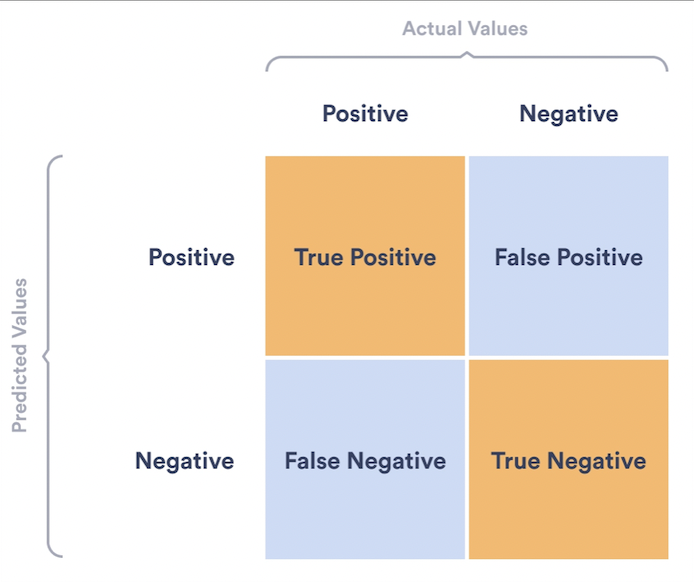


Given the confusion matrix, we can calculate various metrics such as accuracy, precision, recall, F1 score etc.

For our task, we will calculate the test accuracy. The formula for this is: \\

> Accuracy = $\frac{TP + TN}{TP + FP + TN + FN}$

Evaluate the performance using the Confusion Matrix using [MulticlassMetrics](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.evaluation.MulticlassMetrics.html) object in the SparkML Regression library. Store the Confusion Matrix as an numpy array named  `confusion_matrix`. \\

(*Ignore any warnings you may get*)

In [191]:
# TO-DO: Import required libraries
from pyspark.mllib.evaluation import MulticlassMetrics

# TO-DO: Select appropriate columns to use MulticlassMetrics
predictionAndLabels = predictions.select(['prediction','booking_status']).withColumn('label', F.col('booking_status').cast(FloatType())).orderBy('prediction')
predictionAndLabels = predictionAndLabels.select(['prediction','label'])

# TO-DO: Instantiate metrics objects
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))

# TO-DO: Create confusion matrix and store it as a numpy array named "confusion_matrix"
confusion_matrix = metrics.confusionMatrix().toArray()

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [192]:
confusion_matrix

array([[4243.,  522.],
       [ 883., 1477.]])

Now, calculate the test accuracy using the Confusion Matrix obtained above and store it in a variable called `test_accuracy`.

In [193]:
# TO-DO: Calculate test accuracy using the confusion matrix and store it as "test_accuracy"
test_accuracy = (4243+1477)/(4243+1477+883+522)

In [194]:
# Grader cell (6 points)
grader.grade(test_case_id = 'check_unreg_logistic', answer = (train_accuracy, test_accuracy, confusion_matrix))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **2.3.2** Regularized Logistic Regression [8 pts]

Now, we will add regularization – LASSO (L1), Ridge (L2) and elastic net (combination of L1 and L2), to avoid overfitting. You can play around with different regularization hyperparameters when initializing the 3 different regularized logistic regression models. 

Compare these with each other and with the unregularized regression performed in 2.3.1.

Make sure to evaluate the performance on test data using the same methodology as above (using a confusion matrix to calculate the accuracy).

**Note**: Just like 2.3.1, set `maxIter` to a suitable value.

#### (a) LASSO (L1)

First, implement a LASSO Logistic Regression model using SparkML and call it `l1_model`, fit it on `train_sdf` and get predictions using `test_sdf`. Get the training accuracy and store it as `l1_train_accuracy`.

In [195]:
# TO-DO: Instantiate LASSO/L1 regularized model as "l1_model"
l1_model = LogisticRegression(featuresCol = 'features', labelCol = 'booking_status', maxIter=5, elasticNetParam=1, regParam=0.1)

# TO-DO: Fit and Transform using "l1_model"
l1_model = l1_model.fit(train_sdf)

# TO-DO: Store training accuracy as "l1_train_accuracy"
l1_train_accuracy = l1_model.summary.accuracy

predictions = l1_model.transform(test_sdf)

predictionAndLabels = predictions.select(['prediction','booking_status']).withColumn('label', F.col('booking_status').cast(FloatType())).orderBy('prediction')
predictionAndLabels = predictionAndLabels.select(['prediction','label'])
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))

From the predictions, create a confusion matrix and use it to get the test accuracy. Store this accuracy value as `l1_test_accuracy`.

In [196]:
# TO-DO: Create the Confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix

array([[4607.,  158.],
       [1864.,  496.]])

In [197]:
# TO-DO: Calculate the test accuracy as done in the previous section. Store test accuracy as "l1_test_accuracy"
l1_test_accuracy = (4607+496)/(4607+496+158+1864)
l1_test_accuracy, metrics.accuracy

(0.7162105263157895, 0.7162105263157895)

#### (b) Ridge (L2)

Next, implement a Ridge Logistic Regression model using SparkML and call it `l2_model`, fit it on `train_sdf` and get predictions using `test_sdf`. Get the training accuracy and store it as `l2_train_accuracy`.

In [198]:
# TO-DO: Instantiate Ridge/L2 regularized model as "l2_model"
l2_model = LogisticRegression(featuresCol = 'features', labelCol = 'booking_status', maxIter=5, elasticNetParam=0, regParam=0.1)


# TO-DO: Fit and Transform using "l2_model"
l2_model = l2_model.fit(train_sdf)

# TO-DO: Store training accuracy as "l2_train_accuracy"
l2_train_accuracy = l2_model.summary.accuracy

predictions = l2_model.transform(test_sdf)

predictionAndLabels = predictions.select(['prediction','booking_status']).withColumn('label', F.col('booking_status').cast(FloatType())).orderBy('prediction')
predictionAndLabels = predictionAndLabels.select(['prediction','label'])
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))

From the predictions, create a confusion matrix and use it to get the test accuracy. Store this accuracy value as `l2_test_accuracy`.

In [199]:
# TO-DO: Create the Confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix

array([[4512.,  253.],
       [1291., 1069.]])

In [200]:
# TO-DO: Calculate the test accuracy as done in the previous section. Store test accuracy as "l2_test_accuracy"
l2_test_accuracy = (4512+1069)/(1291+253+4512+1069)
l2_test_accuracy, metrics.accuracy

(0.783298245614035, 0.783298245614035)

#### (c) Elastic Net

Finally, implement an Elastic Net Logistic Regression model using SparkML and call it `en_model`, fit it on `train_sdf` and get predictions using `test_sdf`. Get the training accuracy and store it as `en_train_accuracy`.

In [201]:
# TO-DO: Instantiate Elastic Net regularized model as "en_model"
en_model = LogisticRegression(featuresCol = 'features', labelCol = 'booking_status', maxIter=5, elasticNetParam=0.5, regParam=0.1)

# TO-DO: Fit and Transform using "en_model"
en_model = en_model.fit(train_sdf)

# TO-DO: Store training accuracy as "en_train_accuracy"
en_train_accuracy = en_model.summary.accuracy

predictions = en_model.transform(test_sdf)

predictionAndLabels = predictions.select(['prediction','booking_status']).withColumn('label', F.col('booking_status').cast(FloatType())).orderBy('prediction')
predictionAndLabels = predictionAndLabels.select(['prediction','label'])
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))

From the predictions, create a confusion matrix and use it to get the test accuracy. Store this accuracy value as `en_test_accuracy`.

In [202]:
# TO-DO: Create the Confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix

array([[4601.,  164.],
       [1575.,  785.]])

In [203]:
# TO-DO: Calculate the test accuracy as done in the previous section. Store test accuracy as "en_test_accuracy"
en_test_accuracy = (4601+785)/(4601+164+1575+785)
en_test_accuracy, metrics.accuracy

(0.7559298245614036, 0.7559298245614036)

In [204]:
#8 points
#Grader cell
grader.grade(test_case_id = 'check_reg_logistic', answer = (l1_model.getElasticNetParam(), l1_model.getRegParam(), l1_train_accuracy, l1_test_accuracy,
                                                            l2_model.getElasticNetParam(), l2_model.getRegParam(), l2_train_accuracy, l2_test_accuracy,
                                                            en_model.getElasticNetParam(), en_model.getRegParam(), en_train_accuracy, en_test_accuracy))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **2.3.3** Random Forest Classification [8 pts]

If you are looking to win Kaggle competitions, you definitely must know about Random Forests, Boosted Trees, etc. These ensemble methods generalize and work surprisingly well for a lot of classification problems and sometimes for regression problems (though regression trees are not the focus of this course).

Let's give it a go. Similar to what you did for the Logistic Regression model, create a Random Forest classifier model and name it `rf` and fit it to the training data. Call the fitted model `rf_model`.

**Note1:** Set the `random_seed` to 42 and set the argument `seed = random_seed` while creating `rf` as a RandomForest object. \\
**Note2:** Set `maxDepth` to a reasonable value (e.g. 10) to find a good balance between performance and computation time.

In [205]:
# TO-DO: Import required libraries
from pyspark.ml.classification import RandomForestClassifier

# TO-DO: Set random_seed to 42
random_seed = 42

# TO-DO: Instantiate the RF Model and call it "rf", then fit it on the training data
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'booking_status', seed = random_seed, maxDepth=10)
rf = rf.fit(train_sdf)

This time, get predictions on both the training and testing sets, and store them as `train_pred` and `test_pred` respectively.

In [206]:
# TO-DO: Get predictions and save to "train_pred" and "test_pred" respectively
train_pred = rf.transform(train_sdf)
test_pred = rf.transform(test_sdf)

Evaluate using the accuracy metric again, similar to the previous sections.
- Store the confusion matrices as `rf_train_cm` and `rf_test_cm` respectively.
- Store the training and test accuracy as `rf_train_accuracy` and  `rf_test_accuracy` respectively.

In [207]:
train_pred.select(['prediction','booking_status']).withColumn('label', F.col('booking_status').cast(FloatType())).show()

+----------+--------------+-----+
|prediction|booking_status|label|
+----------+--------------+-----+
|       0.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       1.0|           1.0|  1.0|
|       1.0|           1.0|  1.0|
|       0.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       1.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       0.0|           0.0|  0.0|
|       1.0|           1.0|  1.0|
|       1.0|           1.0|  1.0|
+----------+--------------+-----+
only showing top 20 rows



In [208]:
# TO-DO: Evaluate the prediction accuracy for train set and call it "rf_train_accuracy"
predictionAndLabels = train_pred.select(['prediction','booking_status']).withColumn('label', F.col('booking_status').cast(FloatType())).orderBy('prediction')
predictionAndLabels = predictionAndLabels.select(['prediction','label'])
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))
rf_train_cm = metrics.confusionMatrix().toArray()
rf_train_accuracy = metrics.accuracy

# TO-DO: Evaluate the prediction accuracy for test set and call it "rf_test_accuracy"
predictionAndLabels = test_pred.select(['prediction','booking_status']).withColumn('label', F.col('booking_status').cast(FloatType())).orderBy('prediction')
predictionAndLabels = predictionAndLabels.select(['prediction','label'])
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))
rf_test_cm = metrics.confusionMatrix().toArray()
rf_test_accuracy = metrics.accuracy

In [209]:
# Grader (8 points)
grader.grade(test_case_id = 'check_random_forest', answer = (rf_train_accuracy, train_pred.count(), rf_test_accuracy, test_pred.count(), rf_train_cm, rf_test_cm))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **2.3.4** Dimensionality Reduction Using PCA [8 pts]

We will again use the powerful PCA to reduce the dimensions and project the data onto a lower dimensional space and fit a logistic regression on the new projected data.

Initialize a PCA model on SparkML, where you select an appropriate number of dimensions, and call it `pca`. Then, fit the model on the training data and get the PCA features from the trained model.

**Hint**: Choose `k` for the PCA model using the explained variance plot you made earlier.

In [210]:
# TO-DO: Import required libraries
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler

# TO-DO: Perform intermediate steps to address scale-variance in PCA
scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                        withStd=False, withMean=True)
scaler = scaler.fit(train_sdf)
train_scaled = scaler.transform(train_sdf)
test_scaled = scaler.transform(test_sdf)

# TO-DO: Instantiate PCA object as "pca" and then fit and transform.
#        Make sure you make a reasonable choice for the number of Principal Components
pca = PCA(k=17, inputCol="scaled_features", outputCol="pcaFeatures")
pca = pca.fit(train_scaled)

train_pca = pca.transform(train_scaled)
test_pca = pca.transform(test_scaled)

Now, create a Logistic Regression model and train it using the PCA features.

In [211]:
# TO-DO: Instantiate Logistic Regression model and call the model object "lr_model"
lr_model = LogisticRegression(featuresCol = 'pcaFeatures', labelCol = 'booking_status', maxIter=5)

# TO-DO: Fit Logistic Regression Model and get predictions
lr_model = lr_model.fit(train_pca)

Calculate the training accuracy using the model's summary and store it in a variable called `train_accuracy_pca`.

In [212]:
# TO-DO: Get training accuracy and store it as `train_accuracy_pca`
train_accuracy_pca = lr_model.summary.accuracy


Evaulate the test performance by creating a confusion matrix and call it `confusion_matrix_pca`. Then, calculate the test accuracy using the confusion matrix  and store it as `test_accuracy_pca`.

In [213]:
# TO-DO: Create confusion matrix and store it as "confusion_matrix_pca"
predictions = lr_model.transform(test_pca)

predictionAndLabels = predictions.select(['prediction','booking_status']).withColumn('label', F.col('booking_status').cast(FloatType())).orderBy('prediction')
predictionAndLabels = predictionAndLabels.select(['prediction','label'])
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple))
confusion_matrix_pca = metrics.confusionMatrix().toArray()

# TO-DO: Calculate test accuracy and store it as "test_accuracy_pca"
test_accuracy_pca = metrics.accuracy


Evaulate the test performance by creating a confusion matrix and call it `confusion_matrix_pca`. Then, calculate the test accuracy using the confusion matrix  and store it as `test_accuracy_pca`.

In [214]:
# Grader cell (8 points)
grader.grade(test_case_id = 'check_pca', answer = (pca.getK(), len(lr_model.coefficients), test_accuracy_pca, test_accuracy_pca, confusion_matrix_pca))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Homework Submission Reminders & Penalties

Good job! You have finished the homework :) The submission instructions are as follows:

* **Double check** that you have the correct PennID (all numbers) in the autograder. 

* **Triple check** that you have all plots shown in this Colab notebook before submitting (otherwise, your submission will be subjected to a **penalty of -5 points**).

*  Go to the "File" tab at the top left of the Colab UI, click "Download .ipynb" and then "Download .py".  **Rename** these two files to `homework4.ipynb` and `homework4.py` respectively and upload them to Gradescope.
  - <ins>**WAIT UNTIL THE GRADESCOPE AUTOGRADER FINISHES RUNNING!**</ins> If we have to manually upload this for you after the deadline, **we will apply a penalty of -10 points** (this stacks with any other penatlies)

* After the autograder finishes running, Remember to click on the "Code" tab and see what your `.ipynb` file looks like on Gradescope.
  - Just like in HW2, if "Large File Hidden" shows up, you MUST fix it. Refer back to [Ed Post \#957](https://edstem.org/us/courses/32226/discussion/2628740) from earlier in this Spring 2023 semester.

* Post any issues with submission on Ed and make sure to keep in mind the late day policy.

* After you submit your code, the teaching staff will manually grade your Colab notebook in order to validate the correctness of your code.